# Medical Image Analysis: Neural Networks

Follow these instructions (https://github.com/antoniosehk/keras-tensorflow-windows-installation) and apply everything that is needed to run tensorflow and keras. Check if your computer has GPU compatible with NVIDIA drivers. If it is not compatible or you do not have GPU, there are two options available:

1) Use CPU. Our project is not going to be super computationally expensive

2) Use Colab, follow the first lecture and check here https://colab.research.google.com/notebooks/gpu.ipynb

# Exercise

## Database

In [1]:
import numpy as np
import tensorflow as tf
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from skimage.measure import block_reduce
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/My Drive/KU/MIA' 
os.chdir(root_path)

Mounted at /content/gdrive


There is a database with chest X-rays with lung segmentaiton. Please use imread from pyplot to read X-rays and lung masks as follows:

(1024, 1024)


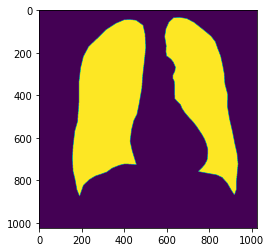

In [2]:
# Reading gif images as numpy arrays
leftLung = imread("Data3/scratch/fold1/masks/left lung/JPCLN001.gif")
rightLung = imread("Data3/scratch/fold1/masks/right lung/JPCLN001.gif")
bothLungs = leftLung + rightLung

print(bothLungs.shape)
plt.imshow(bothLungs)

Exercise 1.1. Read the assignemtn data and separate it into training and testing parts

All raw X-ray images are stored at "Data\scratch\images".
The training and testing masks of the database are stored in two folders named "Data\scratch\fold1\masks\" and "Data\scratch\fold2\masks\", repsectively. The organs of interest include "left lung" and "right lung"

In [3]:
# Images preprocessing

def lung_preprocessing(leftLung_path, rightLung_path, img_path):
  n_cases = len(glob.glob(f"{leftLung_path}*.gif"))
  mask_array = np.empty((n_cases, 256, 256))
  im_array = np.empty((n_cases, 256, 256))

  for i, left_lung in enumerate(glob.glob(f"{leftLung_path}*.gif")):
    # Extract filename
    filename = os.path.basename(left_lung)
    filename_noExt = os.path.splitext(filename)[0]

    # Merge the left and right lung masks
    left_mask = plt.imread(left_lung)
    right_mask = plt.imread(f"{rightLung_path}{filename}")
    mask = left_mask + right_mask

    # Downsample, scale and store mask in mask array
    mask = block_reduce(mask, block_size=(4,4), func=np.mean)
    mask_array[i,:,:] = mask/np.max(mask)

    # Scale and store image in image array
    img = plt.imread(f"{img_path}{filename_noExt}.bmp")
    im_array[i,:,:] = img[:,:,0]/np.max(img)

    i += 1
    if i%10 == 0 or i == n_cases:
      print(f"Processed {i}/{n_cases} images")

  return mask_array, im_array

print("Preprocessing training images:")
mask_array_training, im_array_training = lung_preprocessing(
    leftLung_path = "Data3/scratch/fold1/masks/left lung/",
    rightLung_path = "Data3/scratch/fold1/masks/right lung/", 
    img_path = "Data3/scratch/images/")

print("\nPreprocessing testing images:")
mask_array_testing, im_array_testing = lung_preprocessing(
    leftLung_path = "Data3/scratch/fold2/masks/left lung/",
    rightLung_path = "Data3/scratch/fold2/masks/right lung/", 
    img_path = "Data3/scratch/images/")

# Expand images dimensions
im_array_training = np.expand_dims(np.asarray(im_array_training), axis = 3)
mask_array_training = np.expand_dims(np.asarray(mask_array_training, dtype = np.float), axis = 3)

Preprocessing training images:
Processed 10/124 images
Processed 20/124 images
Processed 30/124 images
Processed 40/124 images
Processed 50/124 images
Processed 60/124 images
Processed 70/124 images
Processed 80/124 images
Processed 90/124 images
Processed 100/124 images
Processed 110/124 images
Processed 120/124 images
Processed 124/124 images

Preprocessing testing images:
Processed 10/123 images
Processed 20/123 images
Processed 30/123 images
Processed 40/123 images
Processed 50/123 images
Processed 60/123 images
Processed 70/123 images
Processed 80/123 images
Processed 90/123 images
Processed 100/123 images
Processed 110/123 images
Processed 120/123 images
Processed 123/123 images


# Train UNet

Exercise 1.2. Adapt some existing implementation of Unet for the segmentation of lung fields. Train the Unet on fold1 of the database.

Check this link for Unet implementation https://github.com/zhixuhao/unet

Here is the implementation of the Unet https://github.com/zhixuhao/unet/blob/master/model.py
Move learning rate (lr) to the parameters of the unet()

Here is an example of how to visualize results of network training, you will need them for your report https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/


In [4]:
# Define model architecture

def unet(pretrained_weights = None, 
         input_size = (256,256,1), 
         learning_rate = 0.0001):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer = Adam(lr = learning_rate), 
                  loss = "binary_crossentropy", 
                  metrics = ["accuracy", "RootMeanSquaredError", "MeanAbsoluteError", "AUC"])
    
    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [82]:
# Hyperparameters model_01
batch_size = 10
epochs = 100
learning_rate = 0.0001
validation_split = 0.15

# Compile the model
model = unet(learning_rate=learning_rate)
model.summary()
tf.keras.backend.clear_session
#tf.keras.utils.plot_model(model, "Unet_graph.png", show_shapes=True)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

<function tensorflow.python.keras.backend.clear_session>

In [83]:
# Training model_01
history = model.fit(im_array_training, 
                    mask_array_training, 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    validation_split = validation_split)

Epoch 1/100
11/11 [==============================] - 24s 2s/step - loss: 0.6554 - accuracy: 0.6617 - root_mean_squared_error: 0.4623 - mean_absolute_error: 0.4065 - auc: 0.7003 - val_loss: 0.4730 - val_accuracy: 0.6886 - val_root_mean_squared_error: 0.3923 - val_mean_absolute_error: 0.3257 - val_auc: 0.8653
Epoch 2/100
11/11 [==============================] - 16s 1s/step - loss: 0.4282 - accuracy: 0.6892 - root_mean_squared_error: 0.3702 - mean_absolute_error: 0.2935 - auc: 0.8983 - val_loss: 0.5834 - val_accuracy: 0.6887 - val_root_mean_squared_error: 0.4324 - val_mean_absolute_error: 0.2582 - val_auc: 0.9067
Epoch 3/100
11/11 [==============================] - 17s 2s/step - loss: 0.3921 - accuracy: 0.6989 - root_mean_squared_error: 0.3569 - mean_absolute_error: 0.2539 - auc: 0.9133 - val_loss: 0.3647 - val_accuracy: 0.8258 - val_root_mean_squared_error: 0.3498 - val_mean_absolute_error: 0.2218 - val_auc: 0.9704
Epoch 4/100
11/11 [==============================] - 16s 1s/step - loss: 

In [96]:
# Visualize the results
def visualize_metrics(model_history, 
                      title=None,
                      subtitles=None, 
                      grid=True, 
                      figsize=(18,4), 
                      save=False,
                      filename="metrics"):
  metrics = ["loss", "root_mean_squared_error", "mean_absolute_error", "auc"]
  labels = ["Loss", "MRSE", "MAE", "AUC"]

  fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=figsize)
  for i, ax in enumerate(axes.flatten()):
    ax.plot(model_history.history[f"{metrics[i]}"])
    ax.plot(model_history.history[f"val_{metrics[i]}"])
    ax.set_ylabel(labels[i])
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Validation'])  
    if grid == True:
      ax.grid(zorder=0, color="lightgray")
    if subtitles != None:
      ax.set_title(labels[i])
  if title != None:
    plt.title(title)
  fig.tight_layout()
  if save == True:
    plt.savefig(f"./Week5/plots_handin3/{filename}.png", dpi=300)
  plt.show()

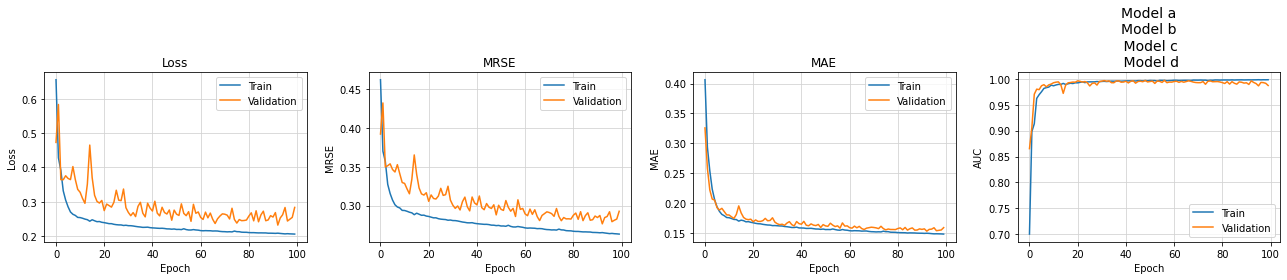

In [97]:
# Save
model.save('Week5/Unet_01.hdf5')

# Plot training process
visualize_metrics(history, subtitles=True, save=True, filename="model_01")

In [ ]:
# Model 02 (batch_size)

# Hyperparameters
batch_size = 20
epochs = 100
learning_rate = 0.0001
validation_split = 0.15

# Compile
model = unet(learning_rate=learning_rate)

# Training
history = model.fit(im_array_training, 
                    mask_array_training, 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    validation_split = validation_split)

Epoch 1/100
6/6 [==============================] - 10s 2s/step - loss: 0.6600 - accuracy: 0.6825 - root_mean_squared_error: 0.4807 - mean_absolute_error: 0.4582 - auc: 0.5127 - val_loss: 0.5661 - val_accuracy: 0.6885 - val_root_mean_squared_error: 0.4349 - val_mean_absolute_error: 0.4026 - val_auc: 0.7895
Epoch 2/100
6/6 [==============================] - 8s 1s/step - loss: 0.5494 - accuracy: 0.6892 - root_mean_squared_error: 0.4284 - mean_absolute_error: 0.3686 - auc: 0.7278 - val_loss: 0.5294 - val_accuracy: 0.6887 - val_root_mean_squared_error: 0.4236 - val_mean_absolute_error: 0.3495 - val_auc: 0.8291
Epoch 3/100
6/6 [==============================] - 8s 1s/step - loss: 0.4858 - accuracy: 0.6893 - root_mean_squared_error: 0.4019 - mean_absolute_error: 0.3267 - auc: 0.8491 - val_loss: 0.4813 - val_accuracy: 0.6887 - val_root_mean_squared_error: 0.4042 - val_mean_absolute_error: 0.2736 - val_auc: 0.9035
Epoch 4/100
6/6 [==============================] - 7s 1s/step - loss: 0.4729 - ac

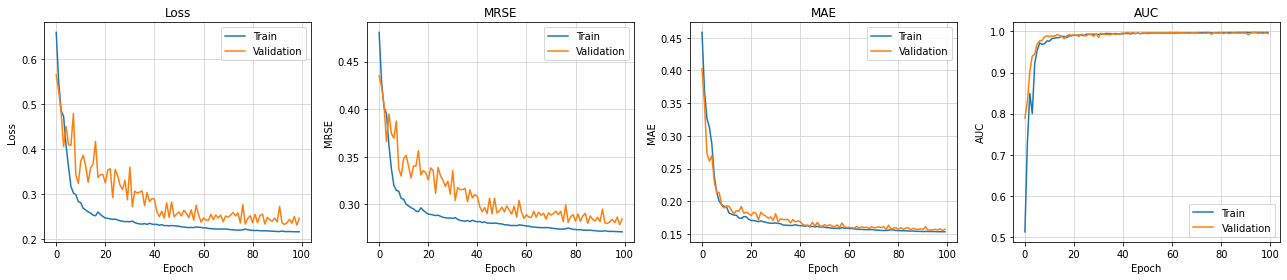

In [ ]:
# Save
model.save('Week5/Unet_02.hdf5')

# Visualize results
visualize_metrics(history, subtitles=True, save=True, filename="model_02")

In [ ]:
# Model 03 (learning_rate)

# Hyperparameters
batch_size = 20
epochs = 100
learning_rate = 0.0002
validation_split = 0.15

# Compile
model = unet(learning_rate=learning_rate)

# Training
history = model.fit(im_array_training, 
                    mask_array_training, 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    validation_split = validation_split)

Epoch 1/100
6/6 [==============================] - 8s 1s/step - loss: 1.1124 - accuracy: 0.6813 - root_mean_squared_error: 0.4788 - mean_absolute_error: 0.3961 - auc: 0.5573 - val_loss: 0.5545 - val_accuracy: 0.6776 - val_root_mean_squared_error: 0.4332 - val_mean_absolute_error: 0.3756 - val_auc: 0.7818
Epoch 2/100
6/6 [==============================] - 8s 1s/step - loss: 0.5004 - accuracy: 0.7053 - root_mean_squared_error: 0.4045 - mean_absolute_error: 0.3532 - auc: 0.8290 - val_loss: 0.5221 - val_accuracy: 0.7145 - val_root_mean_squared_error: 0.4229 - val_mean_absolute_error: 0.2973 - val_auc: 0.8377
Epoch 3/100
6/6 [==============================] - 8s 1s/step - loss: 0.4626 - accuracy: 0.8025 - root_mean_squared_error: 0.3904 - mean_absolute_error: 0.3007 - auc: 0.8515 - val_loss: 0.4352 - val_accuracy: 0.7874 - val_root_mean_squared_error: 0.3826 - val_mean_absolute_error: 0.2665 - val_auc: 0.8993
Epoch 4/100
6/6 [==============================] - 8s 1s/step - loss: 0.4130 - acc

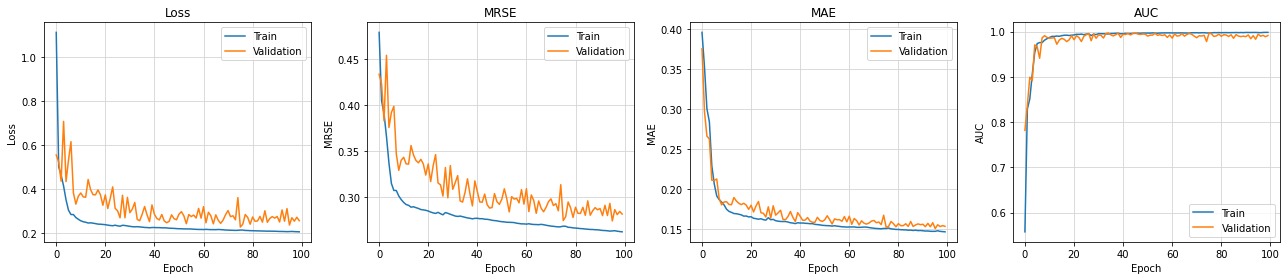

In [ ]:
# Save
model.save('Week5/Unet_03.hdf5')

# Visualize results
visualize_metrics(history, subtitles=True, save=True, filename="model_03")

In [ ]:
# Model 04 (validation_split)

# Hyperparameters
batch_size = 20
epochs = 100
learning_rate = 0.0001
validation_split = 0.3

# Compile
model = unet(learning_rate=learning_rate)

# Training
history = model.fit(im_array_training, 
                    mask_array_training, 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    validation_split = validation_split)

Epoch 1/100
5/5 [==============================] - 7s 1s/step - loss: 0.6918 - accuracy: 0.6026 - root_mean_squared_error: 0.4970 - mean_absolute_error: 0.4956 - auc: 0.5003 - val_loss: 0.6851 - val_accuracy: 0.6807 - val_root_mean_squared_error: 0.4942 - val_mean_absolute_error: 0.4912 - val_auc: 0.5188
Epoch 2/100
5/5 [==============================] - 7s 1s/step - loss: 0.6610 - accuracy: 0.6894 - root_mean_squared_error: 0.4838 - mean_absolute_error: 0.4659 - auc: 0.5224 - val_loss: 0.6436 - val_accuracy: 0.6850 - val_root_mean_squared_error: 0.4762 - val_mean_absolute_error: 0.4630 - val_auc: 0.5798
Epoch 3/100
5/5 [==============================] - 7s 1s/step - loss: 0.6574 - accuracy: 0.6888 - root_mean_squared_error: 0.4833 - mean_absolute_error: 0.4716 - auc: 0.5473 - val_loss: 0.6455 - val_accuracy: 0.6831 - val_root_mean_squared_error: 0.4779 - val_mean_absolute_error: 0.4620 - val_auc: 0.5642
Epoch 4/100
5/5 [==============================] - 7s 1s/step - loss: 0.6294 - acc

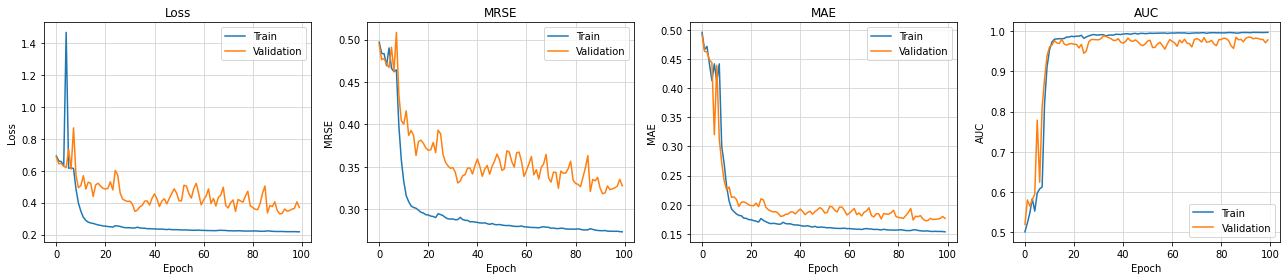

In [ ]:
# Save
model.save('Week5/Unet_04.hdf5')

# Visualize results
visualize_metrics(history, subtitles=True, save=True, filename="model_04")

In [ ]:
# Model 05 (validation_split, learnint_rate)

# Hyperparameters
batch_size = 15
epochs = 100
learning_rate = 0.00008
validation_split = 0.33

# Compile
model = unet(learning_rate=learning_rate)

# Training
history = model.fit(im_array_training, 
                    mask_array_training, 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    validation_split = validation_split)

Epoch 1/100
6/6 [==============================] - 12s 2s/step - loss: 0.7191 - accuracy: 0.6132 - root_mean_squared_error: 0.4910 - mean_absolute_error: 0.4182 - auc: 0.5460 - val_loss: 0.5587 - val_accuracy: 0.6869 - val_root_mean_squared_error: 0.4377 - val_mean_absolute_error: 0.3571 - val_auc: 0.7925
Epoch 2/100
6/6 [==============================] - 6s 1s/step - loss: 0.5216 - accuracy: 0.6883 - root_mean_squared_error: 0.4177 - mean_absolute_error: 0.3519 - auc: 0.8117 - val_loss: 0.5152 - val_accuracy: 0.6871 - val_root_mean_squared_error: 0.4197 - val_mean_absolute_error: 0.3181 - val_auc: 0.8445
Epoch 3/100
6/6 [==============================] - 7s 1s/step - loss: 0.4379 - accuracy: 0.7224 - root_mean_squared_error: 0.3743 - mean_absolute_error: 0.3053 - auc: 0.8999 - val_loss: 0.4722 - val_accuracy: 0.7502 - val_root_mean_squared_error: 0.3989 - val_mean_absolute_error: 0.2691 - val_auc: 0.9040
Epoch 4/100
6/6 [==============================] - 6s 982ms/step - loss: 0.3693 -

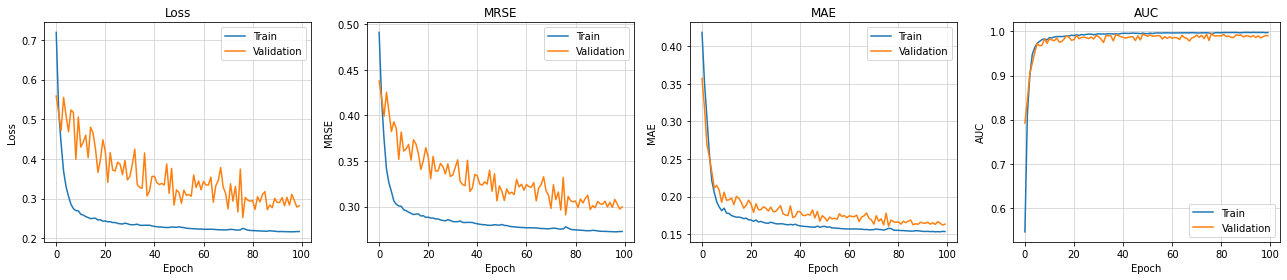

In [ ]:
# Save
model.save('Week5/Unet_05.hdf5')

# Visualize results
visualize_metrics(history, subtitles=True, save=True, filename="model_05")

In [ ]:
# Model 06 (batch_size, validation_split, epochs)

# Hyperparameters
batch_size = 20
epochs = 350
learning_rate = 0.0001
validation_split = 0.2

# Compile
model = unet(learning_rate=learning_rate)

# Training
history = model.fit(im_array_training, 
                    mask_array_training, 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    validation_split = validation_split)

Epoch 1/350
5/5 [==============================] - 15s 3s/step - loss: 0.6586 - accuracy: 0.6889 - root_mean_squared_error: 0.4753 - mean_absolute_error: 0.4359 - auc: 0.5338 - val_loss: 0.5961 - val_accuracy: 0.6903 - val_root_mean_squared_error: 0.4481 - val_mean_absolute_error: 0.4337 - val_auc: 0.7944
Epoch 2/350
5/5 [==============================] - 7s 1s/step - loss: 0.5497 - accuracy: 0.6889 - root_mean_squared_error: 0.4273 - mean_absolute_error: 0.3883 - auc: 0.8151 - val_loss: 0.4837 - val_accuracy: 0.6903 - val_root_mean_squared_error: 0.4000 - val_mean_absolute_error: 0.3219 - val_auc: 0.9044
Epoch 3/350
5/5 [==============================] - 7s 1s/step - loss: 0.4854 - accuracy: 0.6889 - root_mean_squared_error: 0.3990 - mean_absolute_error: 0.3301 - auc: 0.8561 - val_loss: 0.4353 - val_accuracy: 0.6903 - val_root_mean_squared_error: 0.3771 - val_mean_absolute_error: 0.2877 - val_auc: 0.9181
Epoch 4/350
5/5 [==============================] - 7s 1s/step - loss: 0.4610 - ac

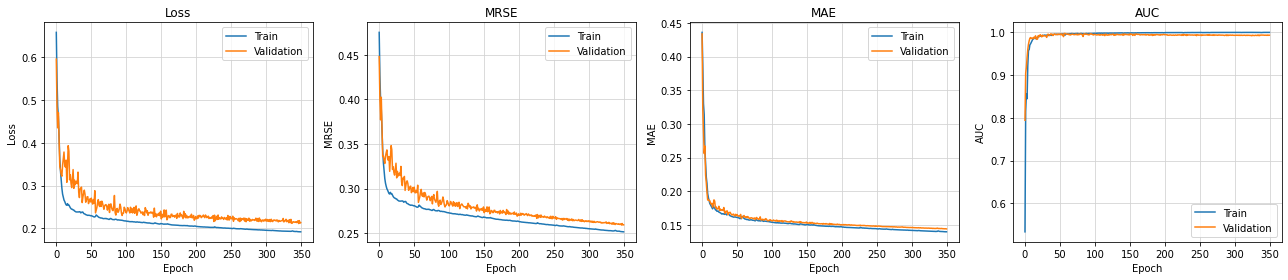

In [ ]:
# Save
model.save('Week5/Unet_06.hdf5')

# Visualize results
visualize_metrics(history, subtitles=True, save=True, filename="model_06")

In [ ]:
# Model 07 (batch_size, validation_split, epochs)

# Hyperparameters
batch_size = 20
epochs = 500
learning_rate = 0.0001
validation_split = 0.2

# Compile
model = unet(learning_rate=learning_rate)

# Training
history = model.fit(im_array_training, 
                    mask_array_training, 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    validation_split = validation_split)

Epoch 1/500
5/5 [==============================] - 8s 2s/step - loss: 0.7883 - accuracy: 0.6842 - root_mean_squared_error: 0.5030 - mean_absolute_error: 0.4613 - auc: 0.5149 - val_loss: 0.6861 - val_accuracy: 0.6886 - val_root_mean_squared_error: 0.4942 - val_mean_absolute_error: 0.4928 - val_auc: 0.5506
Epoch 2/500
5/5 [==============================] - 7s 1s/step - loss: 0.6690 - accuracy: 0.6884 - root_mean_squared_error: 0.4860 - mean_absolute_error: 0.4821 - auc: 0.5343 - val_loss: 0.5773 - val_accuracy: 0.6903 - val_root_mean_squared_error: 0.4429 - val_mean_absolute_error: 0.3697 - val_auc: 0.7514
Epoch 3/500
5/5 [==============================] - 7s 1s/step - loss: 0.6790 - accuracy: 0.6888 - root_mean_squared_error: 0.4873 - mean_absolute_error: 0.4534 - auc: 0.5419 - val_loss: 0.6742 - val_accuracy: 0.6903 - val_root_mean_squared_error: 0.4884 - val_mean_absolute_error: 0.4856 - val_auc: 0.5676
Epoch 4/500
5/5 [==============================] - 7s 1s/step - loss: 0.6555 - acc

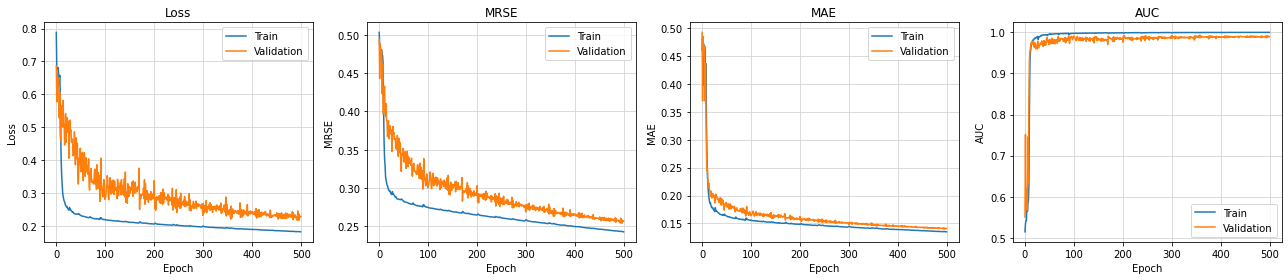

In [ ]:
# Save
model.save('Week5/Unet_07.hdf5')

# Visualize results
visualize_metrics(history, subtitles=True, save=True, filename="model_07")

In [ ]:
# Model 08 (same as before)

# Hyperparameters
batch_size = 20
epochs = 500
learning_rate = 0.0001
validation_split = 0.2

# Compile
model = unet(learning_rate=learning_rate)

# Training
history = model.fit(im_array_training, 
                    mask_array_training, 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    validation_split = validation_split)

Epoch 1/500
5/5 [==============================] - 7s 1s/step - loss: 0.9106 - accuracy: 0.5396 - root_mean_squared_error: 0.5450 - mean_absolute_error: 0.4805 - auc: 0.5546 - val_loss: 0.6180 - val_accuracy: 0.6846 - val_root_mean_squared_error: 0.4634 - val_mean_absolute_error: 0.3605 - val_auc: 0.7320
Epoch 2/500
5/5 [==============================] - 7s 1s/step - loss: 0.5656 - accuracy: 0.6870 - root_mean_squared_error: 0.4350 - mean_absolute_error: 0.3659 - auc: 0.6978 - val_loss: 0.5344 - val_accuracy: 0.6886 - val_root_mean_squared_error: 0.4248 - val_mean_absolute_error: 0.3559 - val_auc: 0.8007
Epoch 3/500
5/5 [==============================] - 7s 1s/step - loss: 0.4899 - accuracy: 0.6885 - root_mean_squared_error: 0.3980 - mean_absolute_error: 0.3493 - auc: 0.8375 - val_loss: 0.5230 - val_accuracy: 0.6900 - val_root_mean_squared_error: 0.4223 - val_mean_absolute_error: 0.3179 - val_auc: 0.8231
Epoch 4/500
5/5 [==============================] - 8s 2s/step - loss: 0.4462 - acc

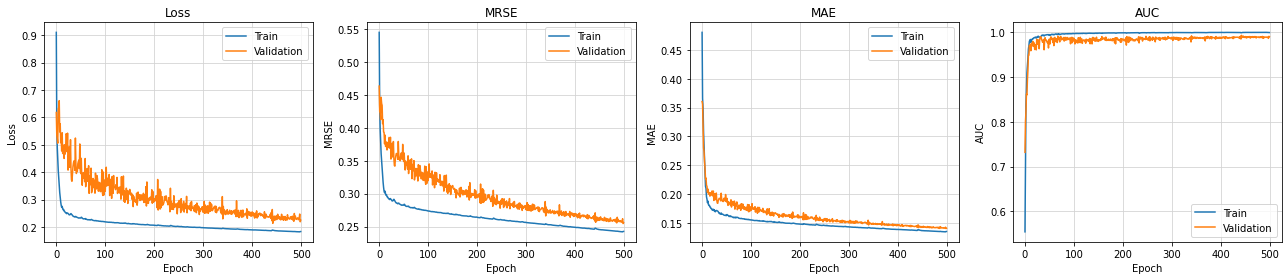

In [ ]:
# Save
model.save('Week5/Unet_08.hdf5')

# Visualize results
visualize_metrics(history, subtitles=True, save=True, filename="model_08")

# Test Unet

Exercise 1.3. Test the Unet performance on fold2. Use Dice coefficient to evaluate the Unet performance.

In [73]:
# Thresholding and functions to evaluate model performance

def thresholding(image_array, threshold):
  image = image_array.copy()
  image[image > threshold] = 1.
  image[image <= threshold] = 0
  return image

def get_dsc(reference, test):
  tp, fn, tn, fp = 0,0,0,0
  for i in range(reference.shape[0]):
    for j in range(test.shape[1]):
      if reference[i,j]==1:
        if test[i,j]==1:
          tp += 1
        else:
          fn += 1
      else:
        if test[i,j]!=1:
          tn += 1
        else:
          fp += 1
  return 2*tp / (2*tp + fp + fn)

# Pixel accuracy, sensitivity, specificity
def diagnostic_metrics(pred, truth):
  tn, fn, tp, fp = 0, 0, 0, 0
  for i in range(pred.shape[0]):
    for j in range(pred.shape[1]):
      if pred[i,j] == 0:
        if pred[i,j] == truth[i,j]:
          tn += 1
        else:
          fn += 1
      if pred[i,j] == 1:
        if pred[i,j] == truth[i,j]:
          tp += 1
        else:
          fp += 1
  sensitivity = tp / (tp + fn)
  specificity = tn / (tn + fp)
  accuracy = (tp + tn) / (pred.shape[0]*pred.shape[1])
  return accuracy, sensitivity, specificity

# RMSE
def RMSE(pred, truth):
  return np.sqrt(np.mean((pred-truth)**2))

# MAE
def MAE(pred, truth):
  return np.mean(abs(pred-truth))

In [100]:
def load_and_test(model_name):
  
  # Load model
  model = load_model(f'Week5/{model_name}.hdf5')

  # Predict
  results = model.predict(np.expand_dims(np.asarray(im_array_testing), axis = 3), batch_size = 5)

  # Evaluate performance
  print(f"\nEvaluating {model_name} test set segmentation:")
  dice_tot, acc_tot, spec_tot, sens_tot = 0, 0, 0, 0

  for i in range(results.shape[0]):
    pred = thresholding(results[i, :, :, 0], 0.5)
    truth = thresholding(mask_array_testing[i], 0.5)
    dice_tot += get_dsc(pred, truth)
    acc, sens, spec = diagnostic_metrics(pred, truth)
    acc_tot += acc
    sens_tot += sens
    spec_tot += spec

    if (i+1)%10 == 0 or i+1 == results.shape[0]:
      print(f"Processed {i+1}/{results.shape[0]} images")

  dice_mean = dice_tot / results.shape[0]
  acc_mean = acc_tot / results.shape[0]
  spec_mean = sens_tot / results.shape[0]
  sens_mean = spec_tot / results.shape[0]
  print(f"\nMean dice on test set: {dice_mean:.4}")
  print(f"Mean accuracy on test set: {acc_mean:.4}")
  print(f"Mean sensitivity on test set: {spec_mean:.4}")
  print(f"Mean specificity on test set: {sens_mean:.4}")
  return results

In [101]:
results_Unet01 = load_and_test("Unet_01")
results_Unet06 = load_and_test("Unet_06")


Evaluating Unet_01 test set segmentation:
Processed 10/123 images
Processed 20/123 images
Processed 30/123 images
Processed 40/123 images
Processed 50/123 images
Processed 60/123 images
Processed 70/123 images
Processed 80/123 images
Processed 90/123 images
Processed 100/123 images
Processed 110/123 images
Processed 120/123 images
Processed 123/123 images

Mean dice on test set: 0.8989
Mean accuracy on test set: 0.9459
Mean sensitivity on test set: 0.8198
Mean specificity on test set: 0.9994

Evaluating Unet_06 test set segmentation:
Processed 10/123 images
Processed 20/123 images
Processed 30/123 images
Processed 40/123 images
Processed 50/123 images
Processed 60/123 images
Processed 70/123 images
Processed 80/123 images
Processed 90/123 images
Processed 100/123 images
Processed 110/123 images
Processed 120/123 images
Processed 123/123 images

Mean dice on test set: 0.9723
Mean accuracy on test set: 0.9838
Mean sensitivity on test set: 0.9621
Mean specificity on test set: 0.9929


In [41]:
# Obtain the indexes of the requested images

def get_filenames(path="Data3/scratch/fold2/masks/left lung/*.gif"):
  filenames = []
  for file_path in glob.glob(f"{path}"):
    filename = os.path.basename(file_path)
    filename_noExt = os.path.splitext(filename)[0]
    filenames.append(filename_noExt)
  return filenames

masks_filenames = get_filenames()

# Requested lungs segmentation
lungs_01 = "JPCLN016"
lungs_02 = "JPCLN048"
lungs_03 = "JPCLN058"

# Obtain indexes
lungs_01_index = masks_filenames.index(lungs_01)
lungs_02_index = masks_filenames.index(lungs_02)
lungs_03_index = masks_filenames.index(lungs_03)

print(f"{lungs_01} index: {lungs_01_index}")
print(f"{lungs_02} index: {lungs_02_index}")
print(f"{lungs_03} index: {lungs_03_index}")

JPCLN016 index: 7
JPCLN048 index: 24
JPCLN058 index: 28


In [102]:
# Compute dice coefficients
pred_01 = thresholding(results_Unet06[lungs_01_index,:,:,0], 0.5)
pred_02 = thresholding(results_Unet06[lungs_02_index,:,:,0], 0.5)
pred_03 = thresholding(results_Unet06[lungs_03_index,:,:,0], 0.5)  
truth_01 = thresholding(mask_array_testing[lungs_01_index], 0.5)   
truth_02 = thresholding(mask_array_testing[lungs_02_index], 0.5)   
truth_03 = thresholding(mask_array_testing[lungs_03_index], 0.5)                         

dice_01 = get_dsc(pred_01, truth_01)
acc_01, sens_01, spec_01 = diagnostic_metrics(pred_01, truth_01)

dice_02 = get_dsc(pred_02, truth_02)
acc_02, sens_02, spec_02 = diagnostic_metrics(pred_02, truth_02)

dice_03 = get_dsc(pred_03, truth_03)
acc_03, sens_03, spec_03 = diagnostic_metrics(pred_03, truth_03)

print(f"{lungs_01}:\nDice coefficient = {dice_01:.4}")
print(f"Accuracy = {acc_01:.4}")
print(f"Sensitivity = {sens_01:.4}")
print(f"Specificity = {spec_01:.4}")

print(f"\n{lungs_02}:\nDice coefficient = {dice_02:.4}")
print(f"Accuracy = {acc_02:.4}")
print(f"Sensitivity = {sens_02:.4}")
print(f"Specificity = {spec_02:.4}")

print(f"\n{lungs_03}:\nDice coefficient = {dice_03:.4}")
print(f"Accuracy = {acc_03:.4}")
print(f"Sensitivity = {sens_03:.4}")
print(f"Specificity = {spec_03:.4}")

JPCLN016:
Dice coefficient = 0.9035
Accuracy = 0.9477
Sensitivity = 0.9699
Specificity = 0.9402

JPCLN048:
Dice coefficient = 0.9378
Accuracy = 0.9763
Sensitivity = 0.9145
Specificity = 0.9913

JPCLN058:
Dice coefficient = 0.9802
Accuracy = 0.983
Sensitivity = 0.9656
Specificity = 0.9964


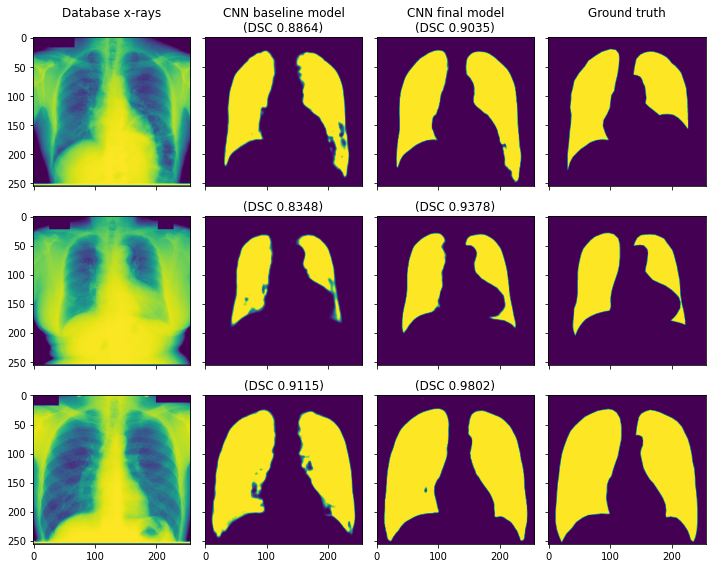

In [106]:
# Plot results for the requested images

def visualize_images(indexes, subtitles=True, figsize=(10,8), save=False, filename=""):
  fig, axes = plt.subplots(nrows=len(indexes), ncols=4, figsize=figsize, sharex=True, sharey=True)
  for n, i in enumerate(indexes):
    dice_01 = get_dsc(thresholding(results_Unet01[i, :, :, 0], 0.5), 
                      thresholding(mask_array_testing[i], 0.5))
    dice_06 = get_dsc(thresholding(results_Unet06[i, :, :, 0], 0.5), 
                      thresholding(mask_array_testing[i], 0.5))
    axes[n,0].imshow(im_array_testing[i], aspect="auto")
    axes[n,1].imshow(results_Unet01[i, :, :, 0], aspect="auto")
    axes[n,2].imshow(results_Unet06[i, :, :, 0], aspect="auto")
    axes[n,3].imshow(mask_array_testing[i], aspect="auto")
    if subtitles == True:
      if n == 0:
        axes[n,0].set_title("Database x-rays\n")
        axes[n,1].set_title(f"CNN baseline model\n(DSC {dice_01:.4})")
        axes[n,2].set_title(f"CNN final model\n(DSC {dice_06:.4})")
        axes[n,3].set_title("Ground truth\n")
      else:
        axes[n,1].set_title(f"(DSC {dice_01:.4})")
        axes[n,2].set_title(f"(DSC {dice_06:.4})")
  fig.tight_layout()
  if save==True:
    plt.savefig(f"./Week5/plots_handin3/{filename}.png", dpi=300)
  plt.show()  

visualize_images([lungs_01_index,lungs_02_index,lungs_03_index], 
                 save=True, filename="final_task_02")

# Tasks for the report

1) Train and test Unet for segmentation of lung fields.

2) Select appropriate par_batch_size, par_epochs, par_validation_split, par_learning_rate. Explain what these parameters mean and how did you choice
   (check this https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/)

3) Plot loss functions for training and validation

4) Plot results for cases JPCLN016, JPCLN048, JPCLN058. Explain why you think the results look like this.